In [193]:
import pandas as pd 
import numpy as np 
import json
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from tqdm import tqdm 
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
import time 

In [3]:
# load data 
mbd_data = pd.read_csv('./outputs/mbd_data.csv')
clusters = json.loads(open('./outputs/clusters_sarimax.json',"r").read())
cluster_keys = ["0","1","2","3","4","5","6","-1"]
mbd_data = mbd_data.sort_values(by=["cfips","first_day_of_month"]).reset_index(drop=True)
mbd_data.median_hh_inc.ffill(inplace=True)
mbd_data.pct_it_workers.ffill(inplace=True)

sc = MinMaxScaler()
mbd_data.median_hh_inc = sc.fit_transform( mbd_data.median_hh_inc.values.reshape(-1,1) ).reshape(-1)

cfips = mbd_data.cfips.unique()

In [4]:
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_pred) + np.abs(y_true)) / 2
    smape_val = np.mean(numerator / denominator)
    return smape_val

In [5]:
# Plot a county 

def plot_county(cfip):
#     cfip = clusters["-1"][0]
    location = mbd_data[mbd_data.cfips == cfip].county.iloc[0] + ", " +mbd_data[mbd_data.cfips == cfip].state.iloc[0]
    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(10, 6))
    dates = pd.date_range(start='2019-08-01', end='2022-12-01', freq='MS')
    values = mbd_data[mbd_data.cfips == cfip]["microbusiness_density"].values

    # Plot the line
    ax.plot(dates, values)

    # Set the axis labels and title
    ax.set_xlabel('Date')
    ax.set_ylabel('Microbusiness Density')
    ax.set_title(f'{location} ( CFIP {cfip} )  ')

    # Rotate the x-axis tick labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    # Show the plot
    plt.show()

In [6]:
cfip = int(list(clusters["0"].keys())[1])
int(cfip) in mbd_data.cfips

True

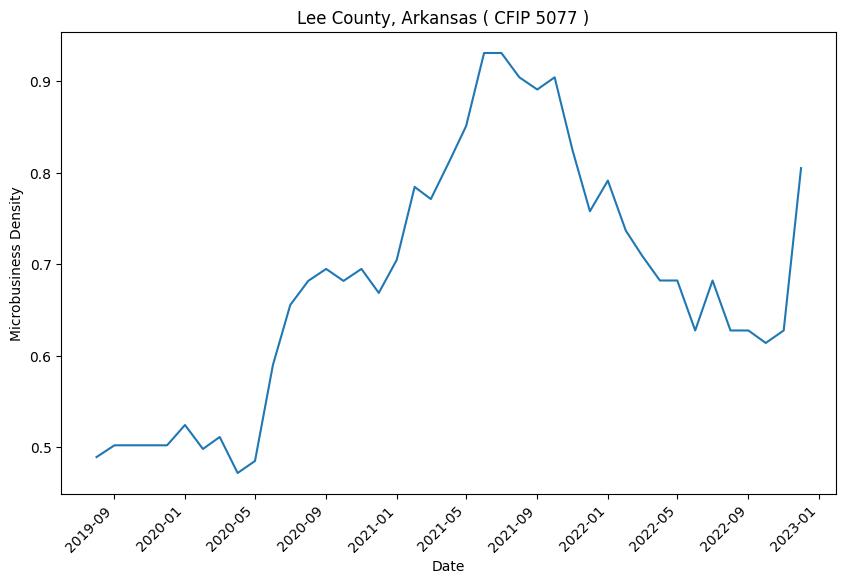

In [7]:
plot_county(cfip) 

In [8]:
def time_series_split(arr, k):
    n = len(arr)
    if k > n:
        return []
    window = [list(arr[i:i+k]) for i in range(n-k+1)]
    return np.array(window)

In [15]:
def train_xgboost_model(cfip, k,lr,depth,estimators,min_train_smape=np.inf, min_test_smape=np.inf,min_train_rmse=np.inf, min_test_rmse=np.inf, best_params=None, return_preds=False):
    data = mbd_data[mbd_data.cfips == cfip]["microbusiness_density"].values
    data = time_series_split(data,k)
    
    train_size = int(0.9*len(data))
    X_train, X_test, y_train, y_test = data[:train_size,:-1],data[train_size:,:-1] , data[:train_size,-1:], data[train_size:,-1:]
    
    # Define the XGBoost model
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror', # Regression task
        learning_rate=lr, # Learning rate
        max_depth=depth, # Maximum depth of the tree
        n_estimators=estimators # Number of trees
    )
    # Train the XGBoost model
    xgb_model.fit(X_train, y_train)

    # Make predictions on the  test data
    y_test_pred = xgb_model.predict(X_test)
    cur_smape = smape(y_test_pred,y_test)
    if cur_smape < min_test_smape : 
        min_test_smape = cur_smape 
        y_train_pred = xgb_model.predict(X_train)

        min_train_smape = smape(y_train,y_train_pred)
        min_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        min_test_rmse = np.sqrt(mean_squared_error(y_test,y_test_pred))
        best_params = {
            "k": k,
            "lr": lr,
            "min_depth": depth, 
            "n_estimators": estimators
        }     
    if return_preds: 
        return y_train, y_train_pred, y_test, y_test_pred
    return min_train_smape, min_test_smape, min_train_rmse, min_test_rmse, best_params

In [17]:
results = json.load(open("./outputs/xgboost_params.json","r"))
# results

In [16]:
df = pd.DataFrame(columns = ["cluster_id","cfips", "train_smape","val_smape", "train_rmse","val_rmse"])
start = time.time()

total = 0 
for cluster_id in clusters: 
    for cfip in clusters[cluster_id]:
        total += 1 

pbar = tqdm(total=total)

for cluster_id in ["-1","4","5","6","0"]:
    if cluster_id in clusters: 
        if cluster_id not in results: 
            results[cluster_id] = {}
        for cfip in clusters[cluster_id]: 
            if cfip in results[cluster_id]: 
                pbar.update(1)
                continue
            best_params = None 
            min_test_smape = np.inf
            min_train_smape = np.inf
            min_train_rmse = np.inf 
            min_test_rmse = np.inf
            for k in range(4,13):
                for lr in np.arange(0.01,0.2,0.01):
                    for depth in range(1,7):
                        for estimators in range(1,30):
                            min_train_smape, min_test_smape, min_train_rmse, min_test_rmse, best_params = train_xgboost_model(int(cfip), k,lr,depth,estimators, min_train_smape,
                                                                                   min_test_smape, min_train_rmse, min_test_rmse, best_params)
            clusters[cluster_id][cfip]['train_smape'], clusters[cluster_id][cfip]['val_smape'],clusters[cluster_id][cfip]['best_params'] = min_train_smape, min_test_smape, best_params
            df.loc[len(df.index)] = [cluster_id, int(cfip), min_train_smape,min_test_smape, min_train_rmse, min_test_rmse]
            results[cluster_id][cfip] = {
                "train_smape": min_train_smape,
                "val_smape": min_test_smape,
                "train_rmse": min_train_rmse,
                "val_rmse": min_test_rmse,
                "best_params": best_params
            }
            json.dump(results,open("./outputs/xgboost_params.json","w"))
            pbar.update(1)

  4%|▍         | 7/159 [19:54<7:20:40, 173.95s/it]

In [58]:
count = 0 
for cluster_id in results: 
    for cfip in results[cluster_id]: 
        if results[cluster_id][cfip]["val_smape"] < 0.02 : 
            # print("YES")
            print(cfip)
            count += 1 
print(count)

32510
1


### Clearly Even XGBoost is not performing well on these counties. Lets see why this is happening 

In [36]:
# plot all counties 

# filtered_counties = []

# for cluster_id in results: 
#     for cfip in results[cluster_id]: 
#         if results[cluster_id][cfip]["val_smape"] < 0.03: 
#             print(results[cluster_id][cfip]["train_smape"])
#             print(results[cluster_id][cfip]["best_params"])
#             plot_county(int(cfip))

In [95]:
cfips_avail = [(cluster_id,cfip,results[cluster_id][cfip]["best_params"]) for cluster_id in results for cfip in results[cluster_id]]
# cfips_avail
cluster_id, cfip, best_params = cfips_avail[4]
print(cfip)

18157


In [96]:
k = best_params["k"]
# k = 4
cfip = int(cfip)
data = mbd_data[mbd_data.cfips == cfip]["microbusiness_density"]
data = time_series_split(data,k)

In [97]:
train_size = int(0.9*len(data))
X_train, X_test, y_train, y_test = data[:train_size,:-1],data[train_size:,:-1] , data[:train_size,-1:], data[train_size:,-1:]

In [98]:
X_train.shape, y_test.shape

((34, 3), (4, 1))

In [99]:
# Define the XGBoost model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', # Regression task
    learning_rate=best_params["lr"], # Learning rate
    max_depth=best_params["min_depth"], # Maximum depth of the tree
    n_estimators=best_params["n_estimators"]# Number of trees
)

# Train the XGBoost model
xgb_model.fit(X_train, y_train)

# Make predictions on the test data
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

smape(y_test_pred,y_test), smape(y_train,y_train_pred)

(0.08215529795692855, 0.10116772790231354)

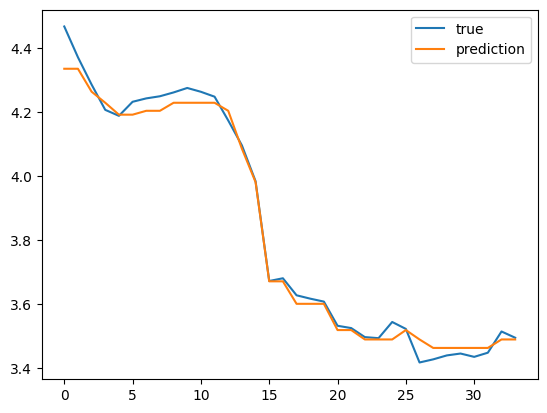

In [100]:
plt.plot(y_train,label='true')
plt.plot(y_train_pred,label='prediction')
plt.legend()
plt.show()

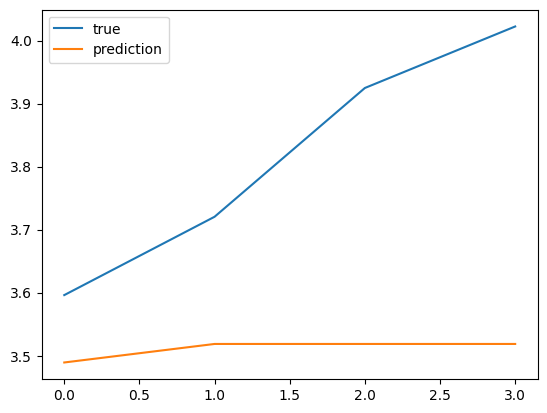

In [101]:
plt.plot(y_test,label='true')
plt.plot(y_test_pred,label='prediction')
plt.legend()
plt.show()